In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
%load_ext autoreload
%autoreload 2

---
## Set Path

In [2]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../'

## Set params based on top 3 GS results
- ML: Final run for GS iloc 52
- Am_like_ML: Final run for GS iloc 103
- Am_20k_users: Final run for GS iloc 106

In [3]:
file_names = ['ml_1m', 'am_like_ml', 'am_20k_users']

In [4]:
pd.read_pickle(path + 'Logs/GS/' + file_names[0] + '_cfrnn_gs_log').sort_values('val_rec@10', ascending=False).iloc[:3]

,all_val_rec@10,val_rec@10,total_val_rec,train_time,loss,val_loss,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,embedding_dim,rnn_units,ckpt_dir,test_users,val_users,pad_value,shift_targets_by
40,"[0.046, 0.04, 0.042, 0.038, 0.042, 0.042, 0.04...",0.066,0.314,285.541392,"[7.621217545687942, 7.1968027542842155, 7.1013...","[7.333751663084953, 7.131995354929278, 7.09382...",100,16,0.20,0.01,30,100,20,../Logs/GS/ckpts/cfrnn_ckpts_ml_1m/ckpts_{epoch},1000,500,3706,1
12,"[0.064, 0.054, 0.052, 0.066]",0.066,0.288,24.493070,"[7.756916454860142, 7.750505563191005, 7.74409...","[7.7483280045645575, 7.741699491228376, 7.7350...",20,64,0.05,0.01,30,100,20,../Logs/GS/ckpts/cfrnn_ckpts_ml_1m/ckpts_{epoch},1000,500,3706,1
39,"[0.044, 0.046, 0.044, 0.048, 0.05, 0.048, 0.05...",0.060,0.302,283.039146,"[4.711129781635406, 4.664943754041153, 4.51959...","[4.710957188760081, 4.630707602347097, 4.41417...",100,16,0.10,0.20,30,100,20,../Logs/GS/ckpts/cfrnn_ckpts_ml_1m/ckpts_{epoch},1000,500,3706,1


In [22]:
ml_1m_params = {
'train_time':0,
'epochs':100,
'BATCH_SIZE':16,
'learning_rate':0.2,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [175]:
pd.read_pickle(path + 'Logs/GS/' + file_names[1] + '_cfrnn_gs_log').sort_values('val_rec@10', ascending=False).iloc[:3]

,all_val_rec@10,learning_rate,train_loss,val_auc,p,q,train_time,total_test_rec,test_rec@10,total_val_rec,val_rec@10,nolf,n_iterations,sample_size,seed,alpha,rho,sigma,reg_user,reg_item
103,"[0.0, 0.028, 0.052, 0.058, 0.064, 0.064, 0.066...","[0.05, 0.05500000000000001, 0.0605000000000000...","[0.7078283074211197, 0.7043634231225636, 0.698...",[],0,0,201.563646,0.255,0.057,0.328,0.072,8,25,141918.4,1234,0.05,1.1,0.5,0.1,0.1
102,"[0.0, 0.0, 0.02, 0.052, 0.052, 0.058, 0.064, 0...","[0.05, 0.05500000000000001, 0.0605000000000000...","[0.7084648622120531, 0.706211066744104, 0.7042...",[],0,0,151.683184,0.237,0.056,0.278,0.070,8,25,88699.0,1234,0.05,1.1,0.5,0.1,0.1
114,"[0.0, 0.054, 0.06, 0.064, 0.07, 0.066, 0.068, ...","[0.12, 0.132, 0.14520000000000002, 0.159720000...","[0.7073379463771455, 0.7014502394575847, 0.691...",[],0,0,91.853372,0.244,0.059,0.280,0.070,8,25,88699.0,1234,0.12,1.1,0.5,0.1,0.1


In [22]:
am_like_ml_params = {
'train_time':0,
'epochs':100,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [177]:
pd.read_pickle(path + 'Logs/GS/' + file_names[2] + '_cfrnn_gs_log').sort_values('val_rec@10', ascending=False).iloc[:3]

,all_val_rec@10,learning_rate,train_loss,val_auc,p,q,train_time,total_test_rec,test_rec@10,total_val_rec,val_rec@10,nolf,n_iterations,sample_size,seed,alpha,rho,sigma,reg_user,reg_item
106,"[0.0, 0.002, 0.002, 0.004, 0.004, 0.012, 0.014...","[0.08, 0.08800000000000001, 0.0968000000000000...","[0.7028022158299345, 0.7002523820573175, 0.698...",[],0,0,211.055301,0.358,0.076,0.300,0.068,8,25,89654.5,1234,0.08,1.1,0.5,0.1,0.1
111,"[0.0, 0.002, 0.006, 0.012, 0.014, 0.016, 0.022...","[0.1, 0.11000000000000001, 0.12100000000000002...","[0.7016037726067214, 0.6973218579632386, 0.693...",[],0,0,269.485003,0.356,0.075,0.294,0.066,8,25,143447.2,1234,0.10,1.1,0.5,0.1,0.1
115,"[0.0, 0.008, 0.014, 0.014, 0.014, 0.022, 0.026...","[0.12, 0.132, 0.14520000000000002, 0.159720000...","[0.701224759533765, 0.6964060667390694, 0.6919...",[],0,0,260.469640,0.345,0.074,0.308,0.064,8,25,143447.2,1234,0.12,1.1,0.5,0.1,0.1


In [22]:
am_20k_users_params = {
'train_time':0,
'epochs':100,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

---
# CFRNN Final Runs

In [179]:
data_paths = ['Data/ML/', 'Data/Amazon/', 'Data/Amazon/']
params = [ml_1m_params, am_like_ml_params, am_20k_users_params]

n_runs = 30

steps = 5
rank_at = 20

In [ ]:
from CFRNN import cfrnn
for data_path, file_name, cfrnn_params in zip(data_paths, file_names, params):
    df = pd.read_pickle(path + data_path + file_name)
    total_items = df.item_id.nunique()
    total_users = df.user_id.nunique()
    
    # Load Train Test Val Split
    train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
    val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
    test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')
    cfrnn = CFRNN(total_users, total_items, cfrnn_params)
    train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn, stats=False)
    val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)
    
    # Create val_set and test_set for prediction procedures
    val_set, left_out_val = leave_last_out(val_set_cfrnn, n_items=1)
    test_set, left_out_test = leave_last_out(test_set_cfrnn, n_items=1)
    
    for i in range(n_runs):
        print(f'run: {i}')
        cfrnn = CFRNN(total_users, total_items, cfrnn_params)
        cfrnn.build_model(summary=False)
        cfrnn.compile_model(train_set=train_set_cfrnn)
                                
        s = time.time()
        cfrnn.train(train_dataset, val_dataset, verbose=0)
        t = time.time() - s
        
        additional_info = {'all_val_rec@10':[]}
        for e in range(1, epochs+1, 1):
            ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, val_set, left_out_val, batch_size=500, rank_at=rank_at, 
                                                    ckpt_dir=f'{path}Logs/GS/ckpts/cfrnn_ckpts_{file_name}/ckpts_{e}')
            cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
            additional_info['all_val_rec@10'].append(cfrnn_metrics['recall'].iloc[2]) 

        ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out_test, batch_size=500, rank_at=rank_at, 
                                                    ckpt_dir=f'{path}Logs/final/ckpts/cfrnn_ckpts_{file_name}/ckpts_{e}')
        cfrnn_test_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
        additional_info['metrics'] = cfrnn_test_metrics
        additional_info['train_time'] = t

        store_path = path + '/Logs/final/' + file_name +  '_cfrnn_log'
        cfrnn.store_model(store_path, additional_info)


run: 0
Training BPR on 25 samples of size 99870
new results created
run: 1
Training BPR on 25 samples of size 99870
Early Stopping, no improvement for 10 iterations at iteration 22
results added
run: 2
Training BPR on 25 samples of size 99870
Early Stopping, no improvement for 10 iterations at iteration 24
results added
run: 3
Training BPR on 25 samples of size 99870
results added
run: 4
Training BPR on 25 samples of size 99870
Early Stopping, no improvement for 10 iterations at iteration 14
results added
run: 5
Training BPR on 25 samples of size 99870
results added
run: 6
Training BPR on 25 samples of size 99870
Early Stopping, no improvement for 10 iterations at iteration 24
results added
run: 7
Training BPR on 25 samples of size 99870
results added
run: 8
Training BPR on 25 samples of size 99870
results added
run: 9
Training BPR on 25 samples of size 99870
Early Stopping, no improvement for 10 iterations at iteration 24
results added
run: 10
Training BPR on 25 samples of size 99870


In [12]:
res_path = path + '/Logs/final/' + file_names[0] + '_bpr_log'
pd.read_pickle(res_path)

,metrics,file_name,all_val_rec@10,learning_rate,train_loss,val_auc,seed,p,q,train_time,nolf,n_iterations,sample_size,alpha,rho,sigma,reg_user,reg_item
0,rank_at hitcounts recall precision ...,ml_1m,"[0.052, 0.054, 0.068, 0.072, 0.072, 0.066, 0.0...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.3085031299399343, 1.9092218261326404, 1.538...",[],0,"[[-0.6273924684215085, 0.37818729120775124, 0....","[[-1.9641139305621802, 2.2464464182198496, 1.9...",623.391109,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
1,rank_at hitcounts recall precision ...,ml_1m,"[0.052, 0.062, 0.062, 0.07, 0.074, 0.07, 0.07,...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.337796505007621, 1.933579149383064, 1.51174...",[],0,"[[-0.7962583457564011, -0.9952621492916598, 0....","[[-0.33065938623548474, -2.5058289286805255, 2...",549.986360,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
2,rank_at hitcounts recall precision ...,ml_1m,"[0.052, 0.048, 0.066, 0.06, 0.07, 0.056, 0.056...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.29552977802305, 1.8970099902263307, 1.54298...",[],0,"[[-0.9289019433243392, 0.4671870242754097, 0.4...","[[-0.6828288770852117, -0.6094166178032037, 0....",594.195363,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
3,rank_at hitcounts recall precision ...,ml_1m,"[0.052, 0.044, 0.06, 0.068, 0.076, 0.064, 0.07...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.361538651500156, 1.9835523885405462, 1.5478...",[],0,"[[0.7362667716471879, -0.8117469187299513, -1....","[[0.8393641148547044, -1.7091744385275545, -3....",595.384859,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
4,rank_at hitcounts recall precision ...,ml_1m,"[0.044, 0.05, 0.052, 0.068, 0.084, 0.072, 0.08...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.3379395561815537, 1.9413450426402479, 1.538...",[],0,"[[-1.0050757337326024, -0.48721535570245855, 1...","[[-2.0991106878512187, -0.2417716640776115, 2....",360.364362,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
5,rank_at hitcounts recall precision ...,ml_1m,"[0.058, 0.066, 0.058, 0.072, 0.078, 0.064, 0.0...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.350252142262873, 1.9612794254970103, 1.5344...",[],0,"[[1.4818574700114409, -0.8823932653510395, 0.6...","[[2.482037042590953, -3.1160207772045516, -0.2...",601.852800,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
6,rank_at hitcounts recall precision ...,ml_1m,"[0.048, 0.054, 0.05, 0.054, 0.07, 0.068, 0.064...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.3637164443312213, 1.9804441195182736, 1.525...",[],0,"[[0.745998127682225, 0.4424716775910101, 0.217...","[[1.399436726499539, 2.2377875100044755, 1.206...",622.793092,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
7,rank_at hitcounts recall precision ...,ml_1m,"[0.06, 0.05, 0.054, 0.06, 0.074, 0.07, 0.07, 0...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.2830792718458257, 1.8880010019096551, 1.532...",[],0,"[[1.0952055659261268, 0.4805892713510339, -0.8...","[[0.865464597639555, 1.0818977759185253, -1.96...",597.333737,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
8,rank_at hitcounts recall precision ...,ml_1m,"[0.052, 0.048, 0.056, 0.062, 0.07, 0.06, 0.066...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.2978445104484906, 1.902231396881514, 1.5511...",[],0,"[[-0.45445045629134284, -1.251640012329015, 1....","[[-1.7074227230498293, -2.7011563080515284, 0....",598.582156,8,25,99870.9,0.05,1.05,0.55,0.001,0.001
9,rank_at hitcounts recall precision ...,ml_1m,"[0.058, 0.05, 0.07, 0.066, 0.076, 0.066, 0.062...","[0.05, 0.052500000000000005, 0.055125000000000...","[3.287167212663013, 1.889650356010325, 1.54511...",[],0,"[[1.4101798429025922, 0.7055534243192934, -0.1...","[[1.818785598478896, 0.6434505629726809, -0.62...",592.517522,8,25,99870.9,0.05,1.05,0.55,0.001,0.001


In [15]:
from Evaluation import get_final_results
res_path = path + '/Logs/final/' + file_names[1] + '_bpr_log'
final_metrics, train_stats, train_time = get_final_results(res_path)

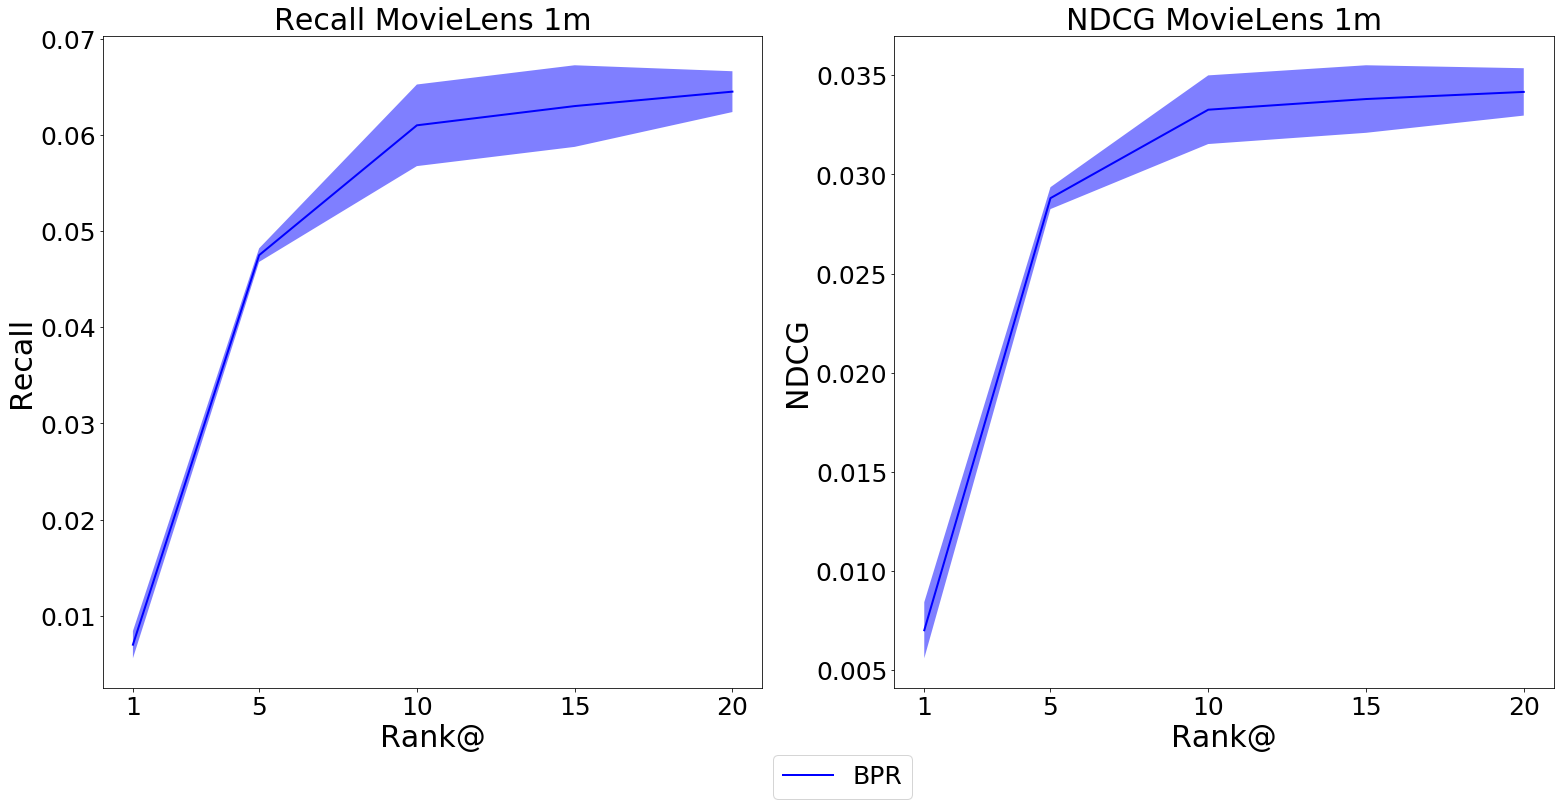

In [16]:
from visualize_results import plot_final_metrics
all_final_results = [final_metrics]
colors = ['blue']
labels = ['BPR']
metrics_to_show = ['recall', 'ndcg']
add_to_title = 'MovieLens 1m'
plot_final_metrics(all_final_results, colors, labels, metrics_to_show, add_to_title)